In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

EVAL_PATH = "HABLA_dataset/eval"
TRAIN_PATH = "HABLA_dataset/train_dev"
SCP_PATH = "HABLA_dataset/scp"


In [26]:
def parse_filename(filename):
    name = filename.replace('.wav', '')
    
    voice_ids = []
    is_synthetic = False
    attack_type = None
    
    if name.startswith(('CycleGAN-', 'StarGAN-', 'Diff-', 'TTS-')):
        is_synthetic = True
        
        if name.startswith('CycleGAN-'):
            attack_type = 'CycleGAN'
            name = name.replace('CycleGAN-', '')
        elif name.startswith('StarGAN-'):
            attack_type = 'StarGAN'
            name = name.replace('StarGAN-', '')
        elif name.startswith('Diff-'):
            attack_type = 'Diff'
            name = name.replace('Diff-', '')
        elif name.startswith('TTS-'):
            attack_type = 'TTS'
            name = name.replace('TTS-', '')
        
        segments = name.split('-')
        for segment in segments:
            parts = segment.split('_')
            if len(parts) >= 2:
                prefix = parts[0]
                if len(prefix) >= 3:
                    country_code = prefix[:2]
                    if country_code in ['ar', 'co', 'cl', 've', 'pe']:
                        voice_id = f"{prefix}_{parts[1]}"
                        voice_ids.append(voice_id)
    else:
        parts = name.split('_')
        if len(parts) >= 2:
            prefix = parts[0]
            if len(prefix) >= 3:
                country_code = prefix[:2]
                if country_code in ['ar', 'co', 'cl', 've', 'pe']:
                    voice_id = f"{prefix}_{parts[1]}"
                    voice_ids.append(voice_id)
    
    return {
        'filename': filename,
        'is_synthetic': is_synthetic,
        'attack_type': attack_type,
        'voice_ids': voice_ids,
        'num_speakers': len(voice_ids)
    }

print("Test cases:")
print("\n1. Real audio:")
ejemplo1 = "arf_00295_0025366257.wav"
print(f"   Input: {ejemplo1}")
resultado1 = parse_filename(ejemplo1)
for key, value in resultado1.items():
    print(f"   {key}: {value}")

Test cases:

1. Real audio:
   Input: arf_00295_0025366257.wav
   filename: arf_00295_0025366257.wav
   is_synthetic: False
   attack_type: None
   voice_ids: ['arf_00295']
   num_speakers: 1


In [27]:
def load_dataset_info(path, dataset_name):
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    print(f"Loading {dataset_name}: {len(files)} files")
    
    data = []
    for filename in files:
        parsed = parse_filename(filename)
        if parsed:
            parsed['dataset'] = dataset_name
            data.append(parsed)
    
    df = pd.DataFrame(data)
    return df

df_eval = load_dataset_info(EVAL_PATH, 'eval')
df_train = load_dataset_info(TRAIN_PATH, 'train_dev')

print(f"\nDatasets loaded:")
print(f"  Eval: {len(df_eval)} files")
print(f"  Train: {len(df_train)} files")

Loading eval: 32327 files
Loading train_dev: 48489 files

Datasets loaded:
  Eval: 32327 files
  Train: 48489 files


# Speaker duplicates

In [28]:
def load_dataset_info(path, dataset_name):
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    print(f"Loading {dataset_name}: {len(files)} files")
    
    data = []
    for filename in files:
        parsed = parse_filename(filename)
        if parsed and parsed['voice_ids']:
            for voice_id in parsed['voice_ids']:
                data.append({
                    'filename': filename,
                    'dataset': dataset_name,
                    'is_synthetic': parsed['is_synthetic'],
                    'attack_type': parsed['attack_type'],
                    'voice_id': voice_id
                })
    
    df = pd.DataFrame(data)
    return df

df_eval = load_dataset_info(EVAL_PATH, 'eval')
df_train = load_dataset_info(TRAIN_PATH, 'train_dev')

print(f"\nDatasets loaded:")
print(f"  Eval: {len(df_eval)} file-speaker pairs")
print(f"  Train: {len(df_train)} file-speaker pairs")

eval_speakers = set(df_eval['voice_id'].unique())
train_speakers = set(df_train['voice_id'].unique())

print(f"\nUnique speakers:")
print(f"  Eval: {len(eval_speakers)} speakers")
print(f"  Train: {len(train_speakers)} speakers")

common_speakers = eval_speakers.intersection(train_speakers)

print(f"\nSpeakers in both datasets: {len(common_speakers)}")

if len(common_speakers) > 0:
    print(f"\nDuplicated speakers found:")
    for speaker in sorted(list(common_speakers)):
        eval_count = len(df_eval[df_eval['voice_id'] == speaker])
        train_count = len(df_train[df_train['voice_id'] == speaker])
        print(f"  {speaker}: {eval_count} appearances in eval, {train_count} appearances in train")
else:
    print("\nNo duplicated speakers. Datasets are properly separated.")

Loading eval: 32327 files
Loading train_dev: 48489 files

Datasets loaded:
  Eval: 51697 file-speaker pairs
  Train: 77119 file-speaker pairs

Unique speakers:
  Eval: 169 speakers
  Train: 169 speakers

Speakers in both datasets: 169

Duplicated speakers found:
  arf_00295: 373 appearances in eval, 595 appearances in train
  arf_00610: 207 appearances in eval, 382 appearances in train
  arf_01208: 14 appearances in eval, 22 appearances in train
  arf_01523: 62 appearances in eval, 116 appearances in train
  arf_02121: 407 appearances in eval, 579 appearances in train
  arf_02436: 399 appearances in eval, 587 appearances in train
  arf_02484: 232 appearances in eval, 312 appearances in train
  arf_02485: 19 appearances in eval, 13 appearances in train
  arf_03034: 396 appearances in eval, 575 appearances in train
  arf_03349: 70 appearances in eval, 95 appearances in train
  arf_03397: 400 appearances in eval, 553 appearances in train
  arf_03398: 17 appearances in eval, 22 appearances

## Distribution


Dataset Distribution Analysis


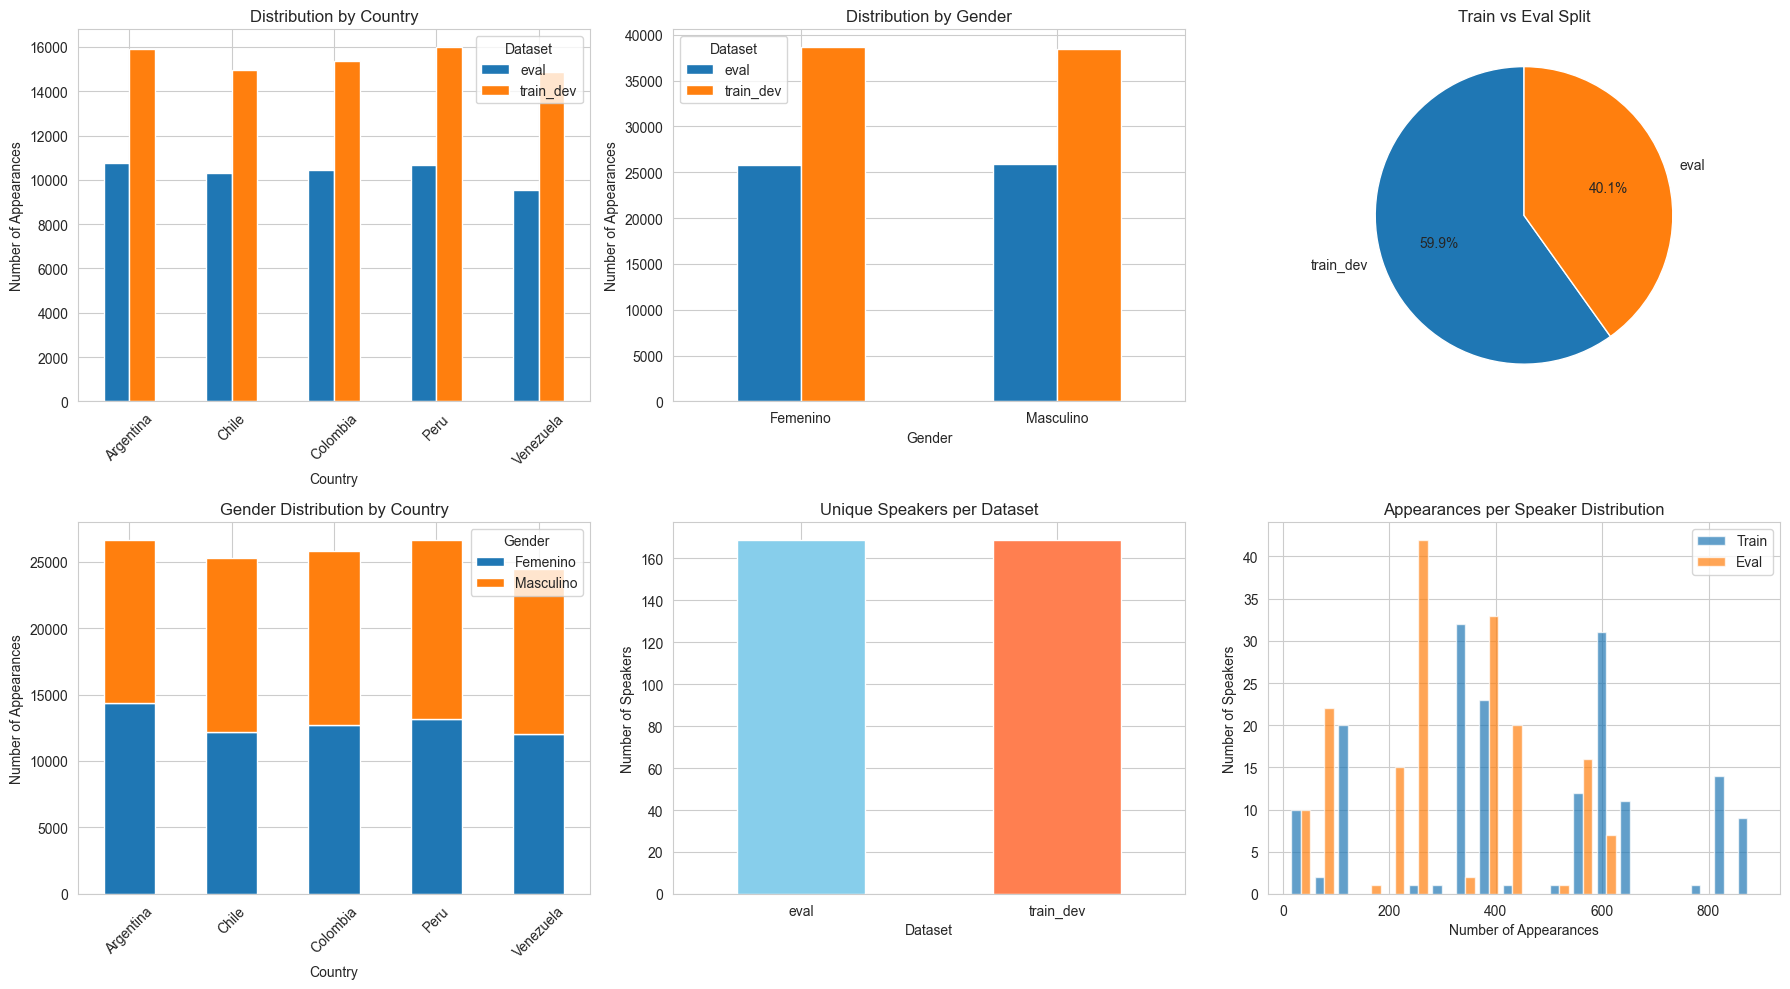

In [29]:
print("\nDataset Distribution Analysis")
print("="*70)

def extract_country_gender(voice_id):
    prefix = voice_id.split('_')[0]
    country_code = prefix[:2]
    country_map = {
        'ar': 'Argentina',
        'co': 'Colombia',
        'cl': 'Chile',
        've': 'Venezuela',
        'pe': 'Peru'
    }
    country = country_map.get(country_code, 'Unknown')
    
    gender_code = prefix[2] if len(prefix) > 2 else 'u'
    gender = 'Femenino' if gender_code == 'f' else 'Masculino' if gender_code == 'm' else 'Unknown'
    
    return country, gender

df_eval['country'] = df_eval['voice_id'].apply(lambda x: extract_country_gender(x)[0])
df_eval['gender'] = df_eval['voice_id'].apply(lambda x: extract_country_gender(x)[1])

df_train['country'] = df_train['voice_id'].apply(lambda x: extract_country_gender(x)[0])
df_train['gender'] = df_train['voice_id'].apply(lambda x: extract_country_gender(x)[1])

df_combined = pd.concat([df_eval, df_train], ignore_index=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

country_dist = df_combined.groupby(['dataset', 'country']).size().unstack(fill_value=0)
country_dist.T.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Distribution by Country')
axes[0,0].set_xlabel('Country')
axes[0,0].set_ylabel('Number of Appearances')
axes[0,0].legend(title='Dataset')
axes[0,0].tick_params(axis='x', rotation=45)

gender_dist = df_combined.groupby(['dataset', 'gender']).size().unstack(fill_value=0)
gender_dist.T.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Distribution by Gender')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Number of Appearances')
axes[0,1].legend(title='Dataset')
axes[0,1].tick_params(axis='x', rotation=0)

dataset_sizes = df_combined['dataset'].value_counts()
axes[0,2].pie(dataset_sizes.values, labels=dataset_sizes.index, autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Train vs Eval Split')

country_gender = df_combined.groupby(['country', 'gender']).size().unstack(fill_value=0)
country_gender.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Gender Distribution by Country')
axes[1,0].set_xlabel('Country')
axes[1,0].set_ylabel('Number of Appearances')
axes[1,0].legend(title='Gender')
axes[1,0].tick_params(axis='x', rotation=45)

speakers_per_dataset = df_combined.groupby('dataset')['voice_id'].nunique()
speakers_per_dataset.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'coral'])
axes[1,1].set_title('Unique Speakers per Dataset')
axes[1,1].set_xlabel('Dataset')
axes[1,1].set_ylabel('Number of Speakers')
axes[1,1].tick_params(axis='x', rotation=0)

appearances_per_speaker_eval = df_eval.groupby('voice_id').size()
appearances_per_speaker_train = df_train.groupby('voice_id').size()
axes[1,2].hist([appearances_per_speaker_train, appearances_per_speaker_eval], 
               bins=20, label=['Train', 'Eval'], alpha=0.7)
axes[1,2].set_title('Appearances per Speaker Distribution')
axes[1,2].set_xlabel('Number of Appearances')
axes[1,2].set_ylabel('Number of Speakers')
axes[1,2].legend()

plt.tight_layout()
plt.show()


Additional Analysis


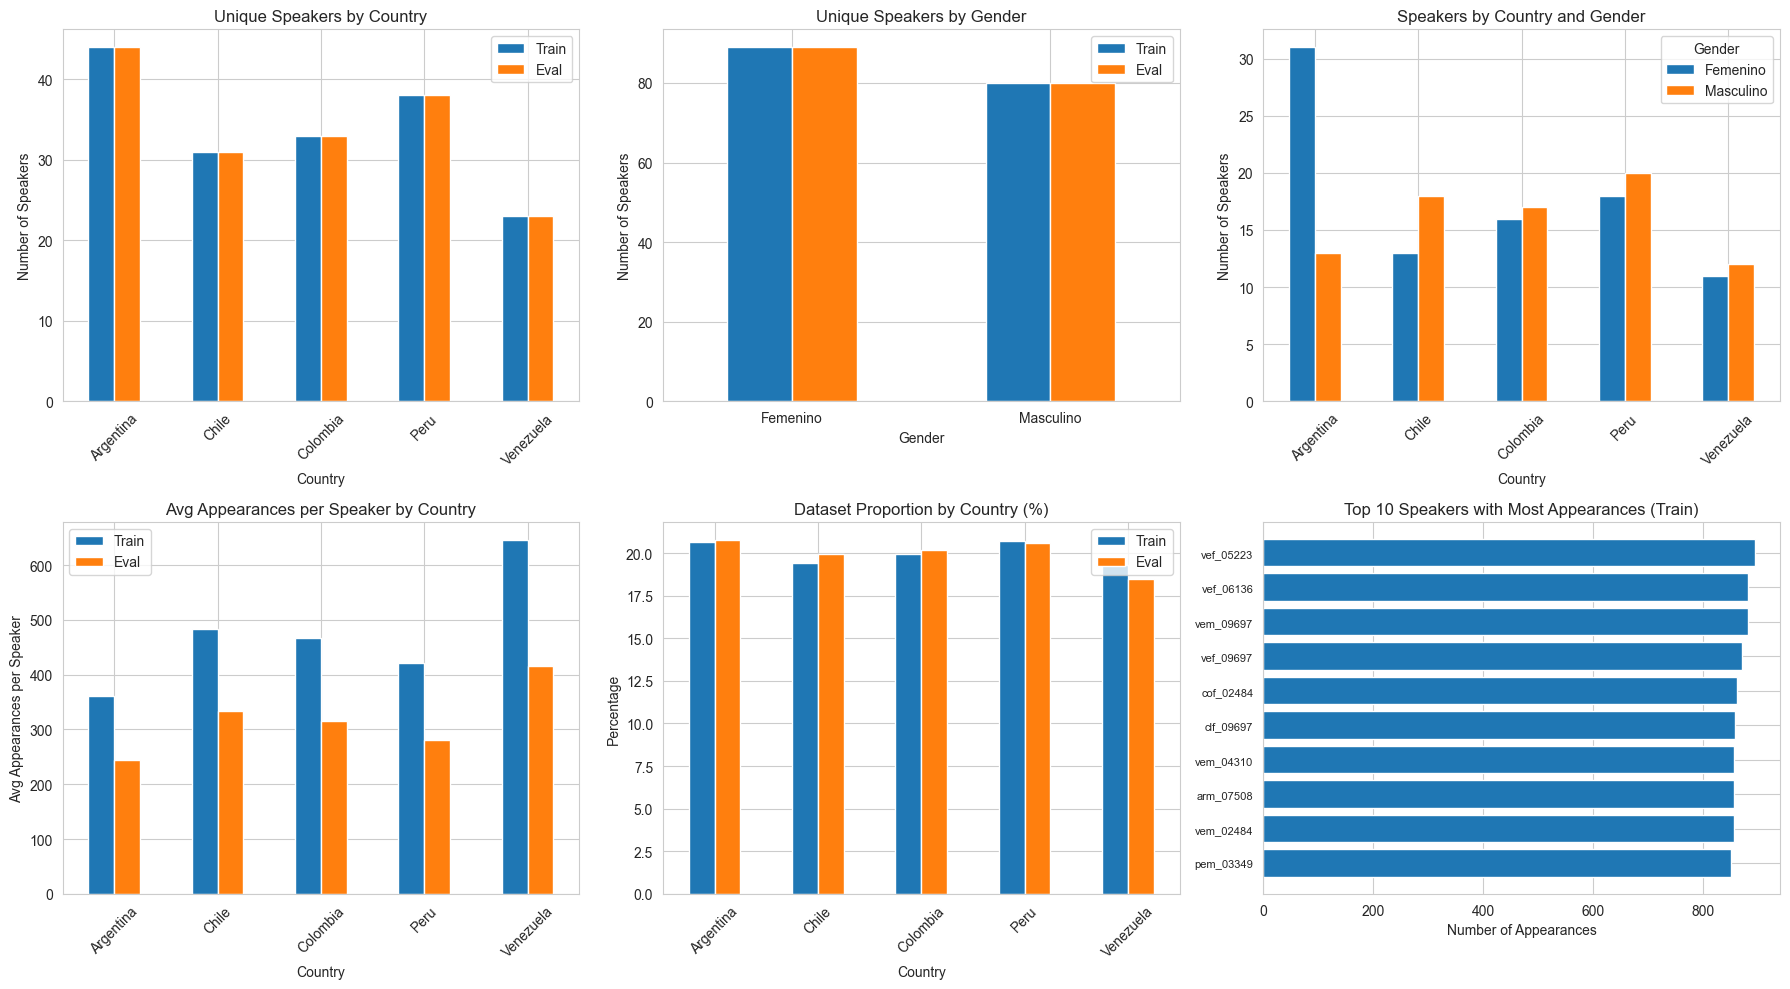

In [30]:
print("\nAdditional Analysis")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

country_speaker_eval = df_eval.groupby('country')['voice_id'].nunique()
country_speaker_train = df_train.groupby('country')['voice_id'].nunique()
country_speakers = pd.DataFrame({'Train': country_speaker_train, 'Eval': country_speaker_eval})
country_speakers.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Unique Speakers by Country')
axes[0,0].set_xlabel('Country')
axes[0,0].set_ylabel('Number of Speakers')
axes[0,0].tick_params(axis='x', rotation=45)

gender_speaker_eval = df_eval.groupby('gender')['voice_id'].nunique()
gender_speaker_train = df_train.groupby('gender')['voice_id'].nunique()
gender_speakers = pd.DataFrame({'Train': gender_speaker_train, 'Eval': gender_speaker_eval})
gender_speakers.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Unique Speakers by Gender')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Number of Speakers')
axes[0,1].tick_params(axis='x', rotation=0)

country_gender_speakers = df_combined.groupby(['country', 'gender'])['voice_id'].nunique().unstack(fill_value=0)
country_gender_speakers.plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Speakers by Country and Gender')
axes[0,2].set_xlabel('Country')
axes[0,2].set_ylabel('Number of Speakers')
axes[0,2].legend(title='Gender')
axes[0,2].tick_params(axis='x', rotation=45)

avg_appearances_country_eval = df_eval.groupby('country')['voice_id'].value_counts().groupby(level=0).mean()
avg_appearances_country_train = df_train.groupby('country')['voice_id'].value_counts().groupby(level=0).mean()
avg_appearances = pd.DataFrame({'Train': avg_appearances_country_train, 'Eval': avg_appearances_country_eval})
avg_appearances.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Avg Appearances per Speaker by Country')
axes[1,0].set_xlabel('Country')
axes[1,0].set_ylabel('Avg Appearances per Speaker')
axes[1,0].tick_params(axis='x', rotation=45)

eval_proportions = df_eval.groupby('country').size() / len(df_eval) * 100
train_proportions = df_train.groupby('country').size() / len(df_train) * 100
proportions = pd.DataFrame({'Train': train_proportions, 'Eval': eval_proportions})
proportions.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Dataset Proportion by Country (%)')
axes[1,1].set_xlabel('Country')
axes[1,1].set_ylabel('Percentage')
axes[1,1].tick_params(axis='x', rotation=45)

top_speakers_train = df_train['voice_id'].value_counts().head(10)
axes[1,2].barh(range(len(top_speakers_train)), top_speakers_train.values)
axes[1,2].set_yticks(range(len(top_speakers_train)))
axes[1,2].set_yticklabels(top_speakers_train.index, fontsize=8)
axes[1,2].set_title('Top 10 Speakers with Most Appearances (Train)')
axes[1,2].set_xlabel('Number of Appearances')
axes[1,2].invert_yaxis()

plt.tight_layout()
plt.show()

In [37]:
from ydata_profiling import ProfileReport

ProfileReport(df_combined, title="Train Dataset Profile Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# SCP

In [ ]:
train_lines = load_lst_file(f"{SCP_PATH}/train.lst")
val_lines = load_lst_file(f"{SCP_PATH}/val.lst")
test_lines = load_lst_file(f"{SCP_PATH}/test_old.lst")

Speakers extracted from .lst files:
  Train: 169 speakers
  Val: 169 speakers
  Test: 169 speakers


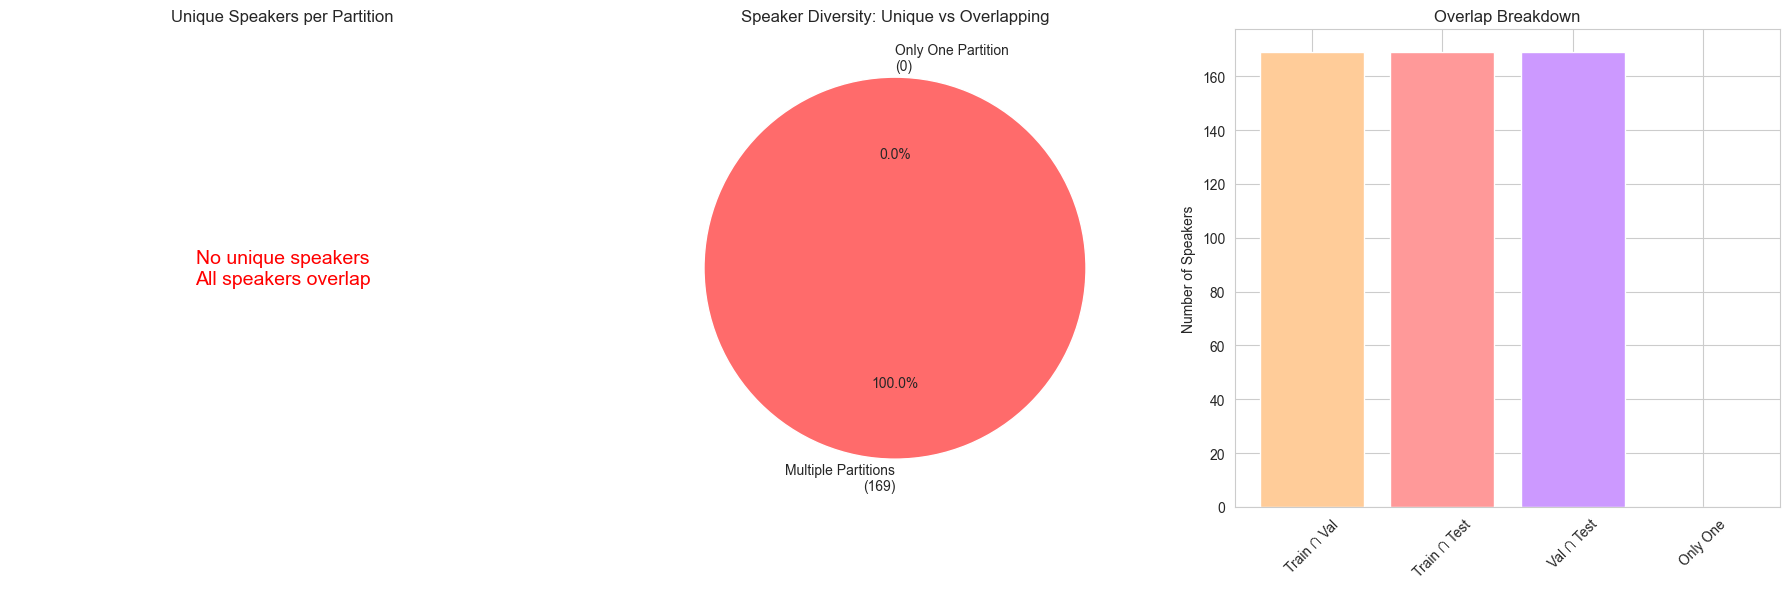


Dataset Partition Statistics:
  Total unique speakers: 169
  Speakers only in Train: 0
  Speakers only in Val: 0
  Speakers only in Test: 0
  Speakers in MULTIPLE partitions: 169

Overlap Details:
  Train ∩ Val: 169 speakers
  Train ∩ Test: 169 speakers
  Val ∩ Test: 169 speakers

Diversity score: 0.00%


In [36]:
def extract_voice_ids_from_line(line):
    voice_ids = []
    
    prefixes = ['CycleGAN-', 'StarGAN-', 'Diff-', 'TTS-']
    is_synthetic = any(prefix in line for prefix in prefixes)
    
    if is_synthetic:
        clean_line = line
        for prefix in prefixes:
            clean_line = clean_line.replace(prefix, '|')
        
        segments = [s for s in clean_line.split('|') if s]
        
        for segment in segments:
            parts = segment.split('_')
            if len(parts) >= 2:
                prefix = parts[0]
                if len(prefix) >= 3 and prefix[:2] in ['ar', 'co', 'cl', 've', 'pe']:
                    voice_id = f"{prefix}_{parts[1]}"
                    voice_ids.append(voice_id)
    else:
        parts = line.split('_')
        if len(parts) >= 2:
            prefix = parts[0]
            if len(prefix) >= 3 and prefix[:2] in ['ar', 'co', 'cl', 've', 'pe']:
                voice_id = f"{prefix}_{parts[1]}"
                voice_ids.append(voice_id)
    
    return list(set(voice_ids))

train_all_speakers = set()
val_all_speakers = set()
test_all_speakers = set()

for line in train_lines:
    voice_ids = extract_voice_ids_from_line(line)
    train_all_speakers.update(voice_ids)

for line in val_lines:
    voice_ids = extract_voice_ids_from_line(line)
    val_all_speakers.update(voice_ids)

for line in test_lines:
    voice_ids = extract_voice_ids_from_line(line)
    test_all_speakers.update(voice_ids)

train_speakers = train_all_speakers
val_speakers = val_all_speakers
test_speakers = test_all_speakers

train_val = train_speakers.intersection(val_speakers)
train_test = train_speakers.intersection(test_speakers)
val_test = val_speakers.intersection(test_speakers)

print(f"Speakers extracted from .lst files:")
print(f"  Train: {len(train_speakers)} speakers")
print(f"  Val: {len(val_speakers)} speakers")
print(f"  Test: {len(test_speakers)} speakers")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

all_speakers = train_speakers.union(val_speakers).union(test_speakers)
total_unique = len(all_speakers)

speakers_only_in_one = 0
speakers_only_in_train = 0
speakers_only_in_val = 0
speakers_only_in_test = 0

for speaker in all_speakers:
    in_train = speaker in train_speakers
    in_val = speaker in val_speakers
    in_test = speaker in test_speakers
    partitions_count = sum([in_train, in_val, in_test])
    
    if partitions_count == 1:
        speakers_only_in_one += 1
        if in_train:
            speakers_only_in_train += 1
        elif in_val:
            speakers_only_in_val += 1
        elif in_test:
            speakers_only_in_test += 1

speakers_in_multiple = total_unique - speakers_only_in_one

partition_unique_counts = [speakers_only_in_train, speakers_only_in_val, speakers_only_in_test]
partition_labels = [f'Train Only\n({speakers_only_in_train})', 
                    f'Val Only\n({speakers_only_in_val})', 
                    f'Test Only\n({speakers_only_in_test})']
colors = ['#ff9999', '#66b3ff', '#99ff99']

if speakers_only_in_one > 0:
    axes[0].pie(partition_unique_counts, labels=partition_labels, autopct='%1.1f%%', 
                startangle=90, colors=colors)
    axes[0].set_title('Unique Speakers per Partition')
else:
    axes[0].text(0.5, 0.5, 'No unique speakers\nAll speakers overlap', 
                 ha='center', va='center', fontsize=14, color='red')
    axes[0].set_title('Unique Speakers per Partition')
    axes[0].axis('off')

overlap_data = [speakers_only_in_one, speakers_in_multiple]
overlap_labels = [f'Only One Partition\n({speakers_only_in_one})', 
                  f'Multiple Partitions\n({speakers_in_multiple})']
overlap_colors = ['#90ee90', '#ff6b6b']

axes[1].pie(overlap_data, labels=overlap_labels, autopct='%1.1f%%', 
            startangle=90, colors=overlap_colors)
axes[1].set_title('Speaker Diversity: Unique vs Overlapping')

overlap_breakdown = {
    'Train ∩ Val': len(train_val),
    'Train ∩ Test': len(train_test),
    'Val ∩ Test': len(val_test),
    'Only One': speakers_only_in_one
}

axes[2].bar(overlap_breakdown.keys(), overlap_breakdown.values(), 
            color=['#ffcc99', '#ff9999', '#cc99ff', '#90ee90'])
axes[2].set_title('Overlap Breakdown')
axes[2].set_ylabel('Number of Speakers')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDataset Partition Statistics:")
print(f"  Total unique speakers: {total_unique}")
print(f"  Speakers only in Train: {speakers_only_in_train}")
print(f"  Speakers only in Val: {speakers_only_in_val}")
print(f"  Speakers only in Test: {speakers_only_in_test}")
print(f"  Speakers in MULTIPLE partitions: {speakers_in_multiple}")
print(f"\nOverlap Details:")
print(f"  Train ∩ Val: {len(train_val)} speakers")
print(f"  Train ∩ Test: {len(train_test)} speakers")
print(f"  Val ∩ Test: {len(val_test)} speakers")
print(f"\nDiversity score: {(speakers_only_in_one/total_unique)*100:.2f}%")

* Revisar si tienen los mismos datos los de test

* Revisar si tienen las mismas muestras reales las particiones frente a lo de zenodo



In [38]:
import os

REAL_PATH = "Latin_America_Spanish_anti_spoofing_dataset/FinalDataset_16khz/Real"

print("Extracting speakers from Real dataset (organized by country)")
print("="*70)

real_speakers_by_country = {}
all_real_speakers = set()

countries = ['Argentina', 'Chile', 'Colombia', 'Peru', 'Venezuela']

for country in countries:
    country_path = os.path.join(REAL_PATH, country)
    if os.path.exists(country_path):
        speakers = [d for d in os.listdir(country_path) if os.path.isdir(os.path.join(country_path, d))]
        real_speakers_by_country[country] = set(speakers)
        all_real_speakers.update(speakers)
        print(f"{country}: {len(speakers)} speakers")
    else:
        print(f"{country}: Directory not found")
        real_speakers_by_country[country] = set()

print(f"\nTotal unique speakers in Real dataset: {len(all_real_speakers)}")

print("\n" + "="*70)
print("Comparing with HABLA_dataset speakers")
print("="*70)

habla_train_speakers = set(df_train['voice_id'].unique())
habla_eval_speakers = set(df_eval['voice_id'].unique())
habla_all_speakers = habla_train_speakers.union(habla_eval_speakers)

print(f"\nHABLA train_dev: {len(habla_train_speakers)} unique speakers")
print(f"HABLA eval: {len(habla_eval_speakers)} unique speakers")
print(f"HABLA total: {len(habla_all_speakers)} unique speakers")

speakers_in_both = all_real_speakers.intersection(habla_all_speakers)
only_in_real = all_real_speakers.difference(habla_all_speakers)
only_in_habla = habla_all_speakers.difference(all_real_speakers)

print(f"\n" + "="*70)
print("Comparison Results")
print("="*70)
print(f"Speakers in BOTH datasets: {len(speakers_in_both)}")
print(f"Speakers ONLY in Real dataset: {len(only_in_real)}")
print(f"Speakers ONLY in HABLA dataset: {len(only_in_habla)}")

if len(speakers_in_both) == len(all_real_speakers) == len(habla_all_speakers):
    print("\n✓ PERFECT MATCH! Both datasets have exactly the same speakers.")
else:
    print("\n✗ MISMATCH! Datasets have different speakers.")
    
    if only_in_real:
        print(f"\nSpeakers only in Real (first 10): {list(only_in_real)[:10]}")
    
    if only_in_habla:
        print(f"\nSpeakers only in HABLA (first 10): {list(only_in_habla)[:10]}")

Extracting speakers from Real dataset (organized by country)
Argentina: 42 speakers
Chile: 29 speakers
Colombia: 31 speakers
Peru: 38 speakers
Venezuela: 22 speakers

Total unique speakers in Real dataset: 162

Comparing with HABLA_dataset speakers

HABLA train_dev: 169 unique speakers
HABLA eval: 169 unique speakers
HABLA total: 169 unique speakers

Comparison Results
Speakers in BOTH datasets: 162
Speakers ONLY in Real dataset: 0
Speakers ONLY in HABLA dataset: 7

✗ MISMATCH! Datasets have different speakers.

Speakers only in HABLA (first 10): ['clm_02436', 'cof_03034', 'arf_01208', 'vef_07508', 'arm_08421', 'clf_02484', 'cof_07049']
